# Description

Runs gaussian mixture model on the z_score_std version of the data.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

2

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=2
env: OPEN_BLAS_NUM_THREADS=2
env: NUMEXPR_NUM_THREADS=2
env: OMP_NUM_THREADS=2


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
np.random.seed(0)

In [6]:
INITIAL_RANDOM_STATE = 60000

## Input data

In [7]:
INPUT_SUBSET = "z_score_std"

In [8]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

## Clustering

In [10]:
from sklearn.mixture import GaussianMixture

In [11]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

In [12]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_MIN"] = 2
CLUSTERING_OPTIONS["K_MAX"] = 60  # sqrt(3749)
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["N_INIT"] = 10
CLUSTERING_OPTIONS["COVARIANCE_TYPE"] = "full"

display(CLUSTERING_OPTIONS)

{'K_MIN': 2,
 'K_MAX': 60,
 'N_REPS_PER_K': 5,
 'N_INIT': 10,
 'COVARIANCE_TYPE': 'full'}

In [13]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in range(CLUSTERING_OPTIONS["K_MIN"], CLUSTERING_OPTIONS["K_MAX"] + 1):
    for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
        clus = GaussianMixture(
            n_components=k,
            n_init=CLUSTERING_OPTIONS["N_INIT"],
            covariance_type=CLUSTERING_OPTIONS["COVARIANCE_TYPE"],
            random_state=random_state,
        )

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        random_state = random_state + 1
        idx = idx + 1

In [14]:
display(len(CLUSTERERS))

295

In [15]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('GaussianMixture #0',
 GaussianMixture(n_components=2, n_init=10, random_state=60000))

('GaussianMixture #1',
 GaussianMixture(n_components=2, n_init=10, random_state=60001))

In [16]:
clustering_method_name = method_name
display(clustering_method_name)

'GaussianMixture'

## Output directory

In [17]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_RUNS_DIR"],
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

# Load input file

In [18]:
data = pd.read_pickle(input_filepath)

In [19]:
data.shape

(3749, 987)

In [20]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.553743,1.851060,-0.095721,0.931603,-0.515196,1.371264,-0.413165,0.729668,0.546338,0.901153,...,1.148776,1.649018,-1.375952,2.203063,0.810199,-0.987048,0.277710,-0.607613,0.572376,-0.660846
100002_raw-Energy,-1.313905,-0.421015,-0.310524,-0.201978,0.233028,0.693838,0.084129,0.572439,0.217866,1.296973,...,0.165430,0.799276,-0.361989,-0.008253,2.063780,-0.930765,-0.147007,1.601938,-0.273553,-0.560822
100003_raw-Protein,-0.645622,-0.997845,0.249039,0.256499,0.422357,0.829189,-0.169004,0.511550,0.002389,-0.057200,...,1.016791,1.019488,-2.148844,-0.065130,0.041052,-0.836118,-0.320571,1.325519,-0.341494,-0.495786
100004_raw-Fat,-0.913924,-1.837183,0.012095,-1.301315,0.205794,1.129114,0.019985,0.376660,-0.810272,0.843611,...,0.544266,0.576714,0.281731,-0.218963,1.258957,-1.131924,0.378545,0.842047,-0.622194,-0.160058
100005_raw-Carbohydrate,-0.523004,0.131379,-0.097802,-0.030526,-0.021500,-0.219116,0.668229,0.365700,1.102347,0.845625,...,-0.344740,0.079274,0.253427,0.236474,1.033895,-0.229105,0.364793,1.776714,0.190531,-1.459641


In [21]:
assert not data.isna().any().any()

# Clustering

## Generate ensemble

In [22]:
from clustering.ensembles.utils import generate_ensemble

In [23]:
ensemble = generate_ensemble(
    data,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 1/295 [00:12<59:47, 12.20s/it]

  1%|          | 2/295 [00:24<59:48, 12.25s/it]

  1%|          | 3/295 [00:36<59:44, 12.27s/it]

  1%|▏         | 4/295 [00:49<59:33, 12.28s/it]

  2%|▏         | 5/295 [01:01<59:18, 12.27s/it]

  2%|▏         | 6/295 [01:19<1:07:22, 13.99s/it]

  2%|▏         | 7/295 [01:37<1:13:05, 15.23s/it]

  3%|▎         | 8/295 [01:55<1:17:00, 16.10s/it]

  3%|▎         | 9/295 [02:13<1:19:36, 16.70s/it]

  3%|▎         | 10/295 [02:31<1:21:20, 17.12s/it]

  4%|▎         | 11/295 [02:56<1:31:32, 19.34s/it]

  4%|▍         | 12/295 [03:20<1:38:10, 20.81s/it]

  4%|▍         | 13/295 [03:44<1:42:20, 21.78s/it]

  5%|▍         | 14/295 [04:09<1:45:47, 22.59s/it]

  5%|▌         | 15/295 [04:33<1:47:57, 23.13s/it]

  5%|▌         | 16/295 [05:06<2:00:48, 25.98s/it]

  6%|▌         | 17/295 [05:37<2:07:21, 27.49s/it]

  6%|▌         | 18/295 [06:08<2:11:48, 28.55s/it]

  6%|▋         | 19/295 [06:40<2:16:16, 29.63s/it]

  7%|▋         | 20/295 [07:10<2:17:07, 29.92s/it]

  7%|▋         | 21/295 [07:50<2:29:45, 32.79s/it]

  7%|▋         | 22/295 [08:27<2:34:21, 33.92s/it]

  8%|▊         | 23/295 [09:04<2:39:06, 35.10s/it]

  8%|▊         | 24/295 [09:42<2:42:10, 35.91s/it]

  8%|▊         | 25/295 [10:20<2:43:32, 36.34s/it]

  9%|▉         | 26/295 [11:03<2:52:06, 38.39s/it]

  9%|▉         | 27/295 [11:49<3:02:20, 40.82s/it]

  9%|▉         | 28/295 [12:33<3:05:05, 41.60s/it]

 10%|▉         | 29/295 [13:16<3:06:55, 42.16s/it]

 10%|█         | 30/295 [14:04<3:13:25, 43.79s/it]

 11%|█         | 31/295 [14:52<3:18:36, 45.14s/it]

 11%|█         | 32/295 [15:41<3:23:02, 46.32s/it]

 11%|█         | 33/295 [16:31<3:26:25, 47.27s/it]

 12%|█▏        | 34/295 [17:19<3:27:33, 47.72s/it]

 12%|█▏        | 35/295 [18:08<3:28:16, 48.06s/it]

 12%|█▏        | 36/295 [19:02<3:35:35, 49.95s/it]

 13%|█▎        | 37/295 [19:57<3:40:03, 51.18s/it]

 13%|█▎        | 38/295 [20:50<3:42:46, 52.01s/it]

 13%|█▎        | 39/295 [21:45<3:44:58, 52.73s/it]

 14%|█▎        | 40/295 [22:40<3:46:49, 53.37s/it]

 14%|█▍        | 41/295 [23:40<3:54:06, 55.30s/it]

 14%|█▍        | 42/295 [24:39<3:58:31, 56.57s/it]

 15%|█▍        | 43/295 [25:39<4:01:57, 57.61s/it]

 15%|█▍        | 44/295 [26:39<4:03:45, 58.27s/it]

 15%|█▌        | 45/295 [27:39<4:05:25, 58.90s/it]

 16%|█▌        | 46/295 [28:45<4:12:39, 60.88s/it]

 16%|█▌        | 47/295 [29:50<4:17:12, 62.23s/it]

 16%|█▋        | 48/295 [30:56<4:20:24, 63.26s/it]

 17%|█▋        | 49/295 [32:02<4:23:09, 64.19s/it]

 17%|█▋        | 50/295 [33:08<4:24:29, 64.77s/it]

 17%|█▋        | 51/295 [34:20<4:31:59, 66.88s/it]

 18%|█▊        | 52/295 [35:32<4:36:33, 68.29s/it]

 18%|█▊        | 53/295 [36:43<4:39:01, 69.18s/it]

 18%|█▊        | 54/295 [37:55<4:40:54, 69.94s/it]

 19%|█▊        | 55/295 [39:07<4:42:10, 70.55s/it]

 19%|█▉        | 56/295 [40:24<4:49:24, 72.66s/it]

 19%|█▉        | 57/295 [41:42<4:54:43, 74.30s/it]

 20%|█▉        | 58/295 [43:00<4:57:07, 75.22s/it]

 20%|██        | 59/295 [44:17<4:58:15, 75.83s/it]

 20%|██        | 60/295 [45:34<4:58:36, 76.24s/it]

 21%|██        | 61/295 [46:57<5:05:22, 78.30s/it]

 21%|██        | 62/295 [48:21<5:10:03, 79.84s/it]

 21%|██▏       | 63/295 [49:44<5:12:43, 80.88s/it]

 22%|██▏       | 64/295 [51:08<5:14:26, 81.67s/it]

 22%|██▏       | 65/295 [52:31<5:14:43, 82.10s/it]

 22%|██▏       | 66/295 [54:00<5:21:23, 84.21s/it]

 23%|██▎       | 67/295 [55:29<5:25:16, 85.60s/it]

 23%|██▎       | 68/295 [56:58<5:27:55, 86.68s/it]

 23%|██▎       | 69/295 [58:26<5:28:35, 87.24s/it]

 24%|██▎       | 70/295 [59:55<5:28:40, 87.65s/it]

 24%|██▍       | 71/295 [1:01:31<5:36:03, 90.02s/it]

 24%|██▍       | 72/295 [1:03:05<5:39:54, 91.46s/it]

 25%|██▍       | 73/295 [1:04:40<5:42:14, 92.50s/it]

 25%|██▌       | 74/295 [1:06:16<5:44:01, 93.40s/it]

 25%|██▌       | 75/295 [1:07:51<5:44:10, 93.87s/it]

 26%|██▌       | 76/295 [1:09:31<5:49:34, 95.77s/it]

 26%|██▌       | 77/295 [1:11:11<5:52:59, 97.15s/it]

 26%|██▋       | 78/295 [1:12:52<5:55:31, 98.30s/it]

 27%|██▋       | 79/295 [1:14:33<5:56:39, 99.07s/it]

 27%|██▋       | 80/295 [1:16:14<5:56:32, 99.50s/it]

 27%|██▋       | 81/295 [1:18:00<6:02:09, 101.54s/it]

 28%|██▊       | 82/295 [1:19:47<6:06:09, 103.14s/it]

 28%|██▊       | 83/295 [1:21:33<6:07:43, 104.08s/it]

 28%|██▊       | 84/295 [1:23:19<6:08:05, 104.67s/it]

 29%|██▉       | 85/295 [1:25:06<6:08:10, 105.19s/it]

 29%|██▉       | 86/295 [1:26:57<6:13:22, 107.19s/it]

 29%|██▉       | 87/295 [1:28:49<6:16:28, 108.60s/it]

 30%|██▉       | 88/295 [1:30:42<6:18:29, 109.71s/it]

 30%|███       | 89/295 [1:32:34<6:19:08, 110.43s/it]

 31%|███       | 90/295 [1:34:25<6:18:39, 110.83s/it]

 31%|███       | 91/295 [1:36:24<6:24:28, 113.08s/it]

 31%|███       | 92/295 [1:38:22<6:27:47, 114.62s/it]

 32%|███▏      | 93/295 [1:40:20<6:29:21, 115.65s/it]

 32%|███▏      | 94/295 [1:42:18<6:29:49, 116.37s/it]

 32%|███▏      | 95/295 [1:44:16<6:29:40, 116.90s/it]

 33%|███▎      | 96/295 [1:46:20<6:34:40, 119.00s/it]

 33%|███▎      | 97/295 [1:48:24<6:37:19, 120.40s/it]

 33%|███▎      | 98/295 [1:50:27<6:38:29, 121.37s/it]

 34%|███▎      | 99/295 [1:52:32<6:39:13, 122.21s/it]

 34%|███▍      | 100/295 [1:54:36<6:39:14, 122.84s/it]

 34%|███▍      | 101/295 [1:56:46<6:43:55, 124.93s/it]

 35%|███▍      | 102/295 [1:58:56<6:46:41, 126.43s/it]

 35%|███▍      | 103/295 [2:01:06<6:48:00, 127.50s/it]

 35%|███▌      | 104/295 [2:03:16<6:48:17, 128.26s/it]

 36%|███▌      | 105/295 [2:05:26<6:47:46, 128.77s/it]

 36%|███▌      | 106/295 [2:07:41<6:52:09, 130.84s/it]

 36%|███▋      | 107/295 [2:09:57<6:54:28, 132.28s/it]

 37%|███▋      | 108/295 [2:12:13<6:55:43, 133.39s/it]

 37%|███▋      | 109/295 [2:14:29<6:55:44, 134.11s/it]

 37%|███▋      | 110/295 [2:16:44<6:54:48, 134.53s/it]

 38%|███▊      | 111/295 [2:19:06<6:59:28, 136.79s/it]

 38%|███▊      | 112/295 [2:21:28<7:02:04, 138.38s/it]

 38%|███▊      | 113/295 [2:23:50<7:02:46, 139.38s/it]

 39%|███▊      | 114/295 [2:26:12<7:03:10, 140.28s/it]

 39%|███▉      | 115/295 [2:28:34<7:02:17, 140.76s/it]

 39%|███▉      | 116/295 [2:31:02<7:06:04, 142.82s/it]

 40%|███▉      | 117/295 [2:33:30<7:07:59, 144.27s/it]

 40%|████      | 118/295 [2:35:57<7:08:32, 145.27s/it]

 40%|████      | 119/295 [2:38:25<7:08:30, 146.08s/it]

 41%|████      | 120/295 [2:40:52<7:06:41, 146.29s/it]

 41%|████      | 121/295 [2:43:25<7:10:19, 148.39s/it]

 41%|████▏     | 122/295 [2:45:58<7:11:56, 149.81s/it]

 42%|████▏     | 123/295 [2:48:31<7:12:06, 150.74s/it]

 42%|████▏     | 124/295 [2:51:05<7:11:48, 151.51s/it]

 42%|████▏     | 125/295 [2:53:37<7:10:22, 151.90s/it]

 43%|████▎     | 126/295 [2:56:17<7:14:02, 154.10s/it]

 43%|████▎     | 127/295 [2:58:56<7:15:32, 155.55s/it]

 43%|████▎     | 128/295 [3:01:35<7:16:14, 156.73s/it]

 44%|████▎     | 129/295 [3:04:14<7:15:07, 157.27s/it]

 44%|████▍     | 130/295 [3:06:53<7:13:54, 157.79s/it]

 44%|████▍     | 131/295 [3:09:37<7:16:31, 159.70s/it]

 45%|████▍     | 132/295 [3:12:22<7:18:12, 161.30s/it]

 45%|████▌     | 133/295 [3:15:06<7:18:02, 162.24s/it]

 45%|████▌     | 134/295 [3:17:51<7:17:17, 162.96s/it]

 46%|████▌     | 135/295 [3:20:35<7:15:49, 163.44s/it]

 46%|████▌     | 136/295 [3:23:25<7:18:04, 165.31s/it]

 46%|████▋     | 137/295 [3:26:16<7:19:45, 166.99s/it]

 47%|████▋     | 138/295 [3:29:07<7:19:41, 168.03s/it]

 47%|████▋     | 139/295 [3:31:57<7:18:42, 168.74s/it]

 47%|████▋     | 140/295 [3:34:47<7:17:15, 169.26s/it]

 48%|████▊     | 141/295 [3:37:43<7:19:35, 171.27s/it]

 48%|████▊     | 142/295 [3:40:40<7:21:04, 172.97s/it]

 48%|████▊     | 143/295 [3:43:37<7:20:50, 174.02s/it]

 49%|████▉     | 144/295 [3:46:33<7:19:37, 174.69s/it]

 49%|████▉     | 145/295 [3:49:29<7:17:56, 175.18s/it]

 49%|████▉     | 146/295 [3:52:32<7:20:39, 177.44s/it]

 50%|████▉     | 147/295 [3:55:34<7:21:07, 178.83s/it]

 50%|█████     | 148/295 [3:58:37<7:20:54, 179.96s/it]

 51%|█████     | 149/295 [4:01:39<7:19:42, 180.70s/it]

 51%|█████     | 150/295 [4:04:42<7:17:55, 181.21s/it]

 51%|█████     | 151/295 [4:07:51<7:20:53, 183.71s/it]

 52%|█████▏    | 152/295 [4:11:00<7:21:55, 185.43s/it]

 52%|█████▏    | 153/295 [4:14:10<7:21:31, 186.56s/it]

 52%|█████▏    | 154/295 [4:17:19<7:20:24, 187.41s/it]

 53%|█████▎    | 155/295 [4:20:28<7:18:35, 187.96s/it]

 53%|█████▎    | 156/295 [4:23:42<7:19:28, 189.70s/it]

 53%|█████▎    | 157/295 [4:26:55<7:18:50, 190.80s/it]

 54%|█████▎    | 158/295 [4:30:08<7:16:55, 191.35s/it]

 54%|█████▍    | 159/295 [4:33:21<7:14:33, 191.72s/it]

 54%|█████▍    | 160/295 [4:36:34<7:12:12, 192.09s/it]

 55%|█████▍    | 161/295 [4:39:52<7:13:20, 194.03s/it]

 55%|█████▍    | 162/295 [4:43:11<7:13:22, 195.50s/it]

 55%|█████▌    | 163/295 [4:46:30<7:12:02, 196.38s/it]

 56%|█████▌    | 164/295 [4:49:48<7:10:06, 197.00s/it]

 56%|█████▌    | 165/295 [4:53:06<7:07:44, 197.42s/it]

 56%|█████▋    | 166/295 [4:56:30<7:08:31, 199.32s/it]

 57%|█████▋    | 167/295 [4:59:54<7:08:22, 200.80s/it]

 57%|█████▋    | 168/295 [5:03:19<7:07:17, 201.87s/it]

 57%|█████▋    | 169/295 [5:06:43<7:05:15, 202.51s/it]

 58%|█████▊    | 170/295 [5:10:07<7:02:54, 203.00s/it]

 58%|█████▊    | 171/295 [5:13:38<7:04:14, 205.28s/it]

 58%|█████▊    | 172/295 [5:17:07<7:03:30, 206.59s/it]

 59%|█████▊    | 173/295 [5:20:37<7:01:47, 207.44s/it]

 59%|█████▉    | 174/295 [5:24:06<6:59:46, 208.15s/it]

 59%|█████▉    | 175/295 [5:27:36<6:57:22, 208.69s/it]

 60%|█████▉    | 176/295 [5:31:12<6:57:51, 210.68s/it]

 60%|██████    | 177/295 [5:34:48<6:57:32, 212.31s/it]

 60%|██████    | 178/295 [5:38:24<6:56:03, 213.36s/it]

 61%|██████    | 179/295 [5:41:59<6:53:43, 214.00s/it]

 61%|██████    | 180/295 [5:45:35<6:51:14, 214.56s/it]

 61%|██████▏   | 181/295 [5:49:17<6:51:55, 216.81s/it]

 62%|██████▏   | 182/295 [5:52:58<6:50:46, 218.11s/it]

 62%|██████▏   | 183/295 [5:56:39<6:48:52, 219.04s/it]

 62%|██████▏   | 184/295 [6:00:21<6:46:37, 219.80s/it]

 63%|██████▎   | 185/295 [6:04:03<6:43:59, 220.36s/it]

 63%|██████▎   | 186/295 [6:07:50<6:43:58, 222.37s/it]

 63%|██████▎   | 187/295 [6:11:37<6:42:47, 223.77s/it]

 64%|██████▎   | 188/295 [6:15:24<6:40:48, 224.75s/it]

 64%|██████▍   | 189/295 [6:19:11<6:38:09, 225.37s/it]

 64%|██████▍   | 190/295 [6:22:58<6:35:25, 225.96s/it]

 65%|██████▍   | 191/295 [6:26:51<6:35:18, 228.06s/it]

 65%|██████▌   | 192/295 [6:30:44<6:34:21, 229.72s/it]

 65%|██████▌   | 193/295 [6:34:38<6:32:23, 230.82s/it]

 66%|██████▌   | 194/295 [6:38:31<6:29:33, 231.42s/it]

 66%|██████▌   | 195/295 [6:42:24<6:26:30, 231.91s/it]

 66%|██████▋   | 196/295 [6:46:23<6:26:03, 233.98s/it]

 67%|██████▋   | 197/295 [6:50:21<6:24:19, 235.30s/it]

 67%|██████▋   | 198/295 [6:54:20<6:22:05, 236.34s/it]

 67%|██████▋   | 199/295 [6:58:18<6:19:16, 237.04s/it]

 68%|██████▊   | 200/295 [7:02:17<6:16:08, 237.56s/it]

 68%|██████▊   | 201/295 [7:06:22<6:15:26, 239.64s/it]

 68%|██████▊   | 202/295 [7:10:26<6:13:44, 241.12s/it]

 69%|██████▉   | 203/295 [7:14:31<6:11:14, 242.11s/it]

 69%|██████▉   | 204/295 [7:18:35<6:08:09, 242.75s/it]

 69%|██████▉   | 205/295 [7:22:39<6:04:55, 243.28s/it]

 70%|██████▉   | 206/295 [7:26:50<6:03:55, 245.34s/it]

 70%|███████   | 207/295 [7:31:00<6:02:01, 246.84s/it]

 71%|███████   | 208/295 [7:35:10<5:59:23, 247.86s/it]

 71%|███████   | 209/295 [7:39:21<5:56:25, 248.67s/it]

 71%|███████   | 210/295 [7:43:31<5:52:50, 249.06s/it]

 72%|███████▏  | 211/295 [7:47:47<5:51:33, 251.12s/it]

 72%|███████▏  | 212/295 [7:52:02<5:49:22, 252.57s/it]

 72%|███████▏  | 213/295 [7:56:19<5:46:37, 253.63s/it]

 73%|███████▎  | 214/295 [8:00:35<5:43:24, 254.38s/it]

 73%|███████▎  | 215/295 [8:04:51<5:39:51, 254.89s/it]

 73%|███████▎  | 216/295 [8:09:13<5:38:19, 256.95s/it]

 74%|███████▎  | 217/295 [8:13:34<5:35:51, 258.35s/it]

 74%|███████▍  | 218/295 [8:17:56<5:32:48, 259.34s/it]

 74%|███████▍  | 219/295 [8:22:17<5:29:09, 259.86s/it]

 75%|███████▍  | 220/295 [8:26:38<5:25:18, 260.25s/it]

 75%|███████▍  | 221/295 [8:31:05<5:23:36, 262.39s/it]

 75%|███████▌  | 222/295 [8:35:32<5:20:56, 263.79s/it]

 76%|███████▌  | 223/295 [8:40:00<5:17:56, 264.95s/it]

 76%|███████▌  | 224/295 [8:44:27<5:14:13, 265.55s/it]

 76%|███████▋  | 225/295 [8:48:54<5:10:14, 265.92s/it]

 77%|███████▋  | 226/295 [8:53:27<5:08:12, 268.00s/it]

 77%|███████▋  | 227/295 [8:58:00<5:05:23, 269.46s/it]

 77%|███████▋  | 228/295 [9:02:33<5:02:04, 270.52s/it]

 78%|███████▊  | 229/295 [9:07:05<4:58:19, 271.20s/it]

 78%|███████▊  | 230/295 [9:11:39<4:54:29, 271.84s/it]

 78%|███████▊  | 231/295 [9:16:20<4:53:01, 274.71s/it]

 79%|███████▊  | 232/295 [9:21:01<4:50:27, 276.63s/it]

 79%|███████▉  | 233/295 [9:25:41<4:46:57, 277.70s/it]

 79%|███████▉  | 234/295 [9:30:22<4:43:12, 278.56s/it]

 80%|███████▉  | 235/295 [9:35:03<4:39:18, 279.31s/it]

 80%|████████  | 236/295 [9:39:48<4:36:26, 281.13s/it]

 80%|████████  | 237/295 [9:44:33<4:32:50, 282.26s/it]

 81%|████████  | 238/295 [9:49:18<4:28:54, 283.07s/it]

 81%|████████  | 239/295 [9:54:03<4:24:44, 283.66s/it]

 81%|████████▏ | 240/295 [9:58:48<4:20:24, 284.09s/it]

 82%|████████▏ | 241/295 [10:03:38<4:17:06, 285.67s/it]

 82%|████████▏ | 242/295 [10:08:26<4:13:01, 286.45s/it]

 82%|████████▏ | 243/295 [10:13:14<4:08:43, 286.99s/it]

 83%|████████▎ | 244/295 [10:18:03<4:04:19, 287.44s/it]

 83%|████████▎ | 245/295 [10:22:52<3:59:53, 287.88s/it]

 83%|████████▎ | 246/295 [10:27:48<3:57:04, 290.31s/it]

 84%|████████▎ | 247/295 [10:32:44<3:53:37, 292.03s/it]

 84%|████████▍ | 248/295 [10:37:40<3:49:38, 293.17s/it]

 84%|████████▍ | 249/295 [10:42:36<3:45:24, 294.02s/it]

 85%|████████▍ | 250/295 [10:47:32<3:40:57, 294.60s/it]

 85%|████████▌ | 251/295 [10:52:33<3:37:36, 296.75s/it]

 85%|████████▌ | 252/295 [10:57:35<3:33:44, 298.23s/it]

 86%|████████▌ | 253/295 [11:02:36<3:29:24, 299.16s/it]

 86%|████████▌ | 254/295 [11:07:38<3:24:54, 299.86s/it]

 86%|████████▋ | 255/295 [11:12:39<3:20:16, 300.41s/it]

 87%|████████▋ | 256/295 [11:17:47<3:16:33, 302.41s/it]

 87%|████████▋ | 257/295 [11:22:53<3:12:21, 303.73s/it]

 87%|████████▋ | 258/295 [11:28:00<3:07:53, 304.68s/it]

 88%|████████▊ | 259/295 [11:33:07<3:03:13, 305.38s/it]

 88%|████████▊ | 260/295 [11:38:14<2:58:23, 305.83s/it]

 88%|████████▊ | 261/295 [11:43:27<2:54:27, 307.86s/it]

 89%|████████▉ | 262/295 [11:48:39<2:50:06, 309.27s/it]

 89%|████████▉ | 263/295 [11:53:51<2:45:15, 309.86s/it]

 89%|████████▉ | 264/295 [11:59:02<2:40:22, 310.41s/it]

 90%|████████▉ | 265/295 [12:04:14<2:35:23, 310.79s/it]

 90%|█████████ | 266/295 [12:09:31<2:31:08, 312.70s/it]

 91%|█████████ | 267/295 [12:14:48<2:26:35, 314.11s/it]

 91%|█████████ | 268/295 [12:20:05<2:21:44, 314.98s/it]

 91%|█████████ | 269/295 [12:25:22<2:16:45, 315.58s/it]

 92%|█████████▏| 270/295 [12:30:39<2:11:39, 315.97s/it]

 92%|█████████▏| 271/295 [12:36:02<2:07:12, 318.03s/it]

 92%|█████████▏| 272/295 [12:41:25<2:02:28, 319.49s/it]

 93%|█████████▎| 273/295 [12:46:50<1:57:41, 321.00s/it]

 93%|█████████▎| 274/295 [12:52:14<1:52:45, 322.15s/it]

 93%|█████████▎| 275/295 [12:57:39<1:47:39, 322.95s/it]

 94%|█████████▎| 276/295 [13:03:10<1:42:57, 325.15s/it]

 94%|█████████▍| 277/295 [13:08:40<1:38:01, 326.73s/it]

 94%|█████████▍| 278/295 [13:14:10<1:32:51, 327.74s/it]

 95%|█████████▍| 279/295 [13:19:40<1:27:34, 328.44s/it]

 95%|█████████▍| 280/295 [13:25:10<1:22:14, 328.97s/it]

 95%|█████████▌| 281/295 [13:30:46<1:17:14, 331.05s/it]

 96%|█████████▌| 282/295 [13:36:22<1:12:02, 332.50s/it]

 96%|█████████▌| 283/295 [13:41:58<1:06:42, 333.55s/it]

 96%|█████████▋| 284/295 [13:47:33<1:01:13, 333.94s/it]

 97%|█████████▋| 285/295 [13:53:07<55:40, 334.03s/it]  

 97%|█████████▋| 286/295 [13:58:50<50:29, 336.58s/it]

 97%|█████████▋| 287/295 [14:04:34<45:10, 338.82s/it]

 98%|█████████▊| 288/295 [14:10:18<39:43, 340.45s/it]

 98%|█████████▊| 289/295 [14:16:02<34:09, 341.59s/it]

 98%|█████████▊| 290/295 [14:21:46<28:31, 342.25s/it]

 99%|█████████▊| 291/295 [14:27:35<22:57, 344.31s/it]

 99%|█████████▉| 292/295 [14:33:26<17:18, 346.15s/it]

 99%|█████████▉| 293/295 [14:39:15<11:34, 347.17s/it]

100%|█████████▉| 294/295 [14:45:05<05:47, 347.88s/it]

100%|██████████| 295/295 [14:50:54<00:00, 348.44s/it]

100%|██████████| 295/295 [14:50:54<00:00, 181.20s/it]

In [24]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(295, 3)

In [25]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
GaussianMixture #0,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
GaussianMixture #1,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
GaussianMixture #2,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
GaussianMixture #3,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2
GaussianMixture #4,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2


In [26]:
ensemble["n_clusters"].value_counts().head()

60    5
16    5
28    5
27    5
26    5
Name: n_clusters, dtype: int64

In [27]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    295.000000
mean      31.000000
std       17.058323
min        2.000000
25%       16.000000
50%       31.000000
75%       46.000000
max       60.000000
Name: n_clusters, dtype: float64

## Testing

In [28]:
assert ensemble_stats["min"] > 1

In [29]:
assert not ensemble["n_clusters"].isna().any()

In [30]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [31]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [32]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

## Add clustering quality measures

In [33]:
from sklearn.metrics import calinski_harabasz_score

In [34]:
ensemble = ensemble.assign(
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x))
)

In [35]:
ensemble.shape

(295, 4)

In [36]:
ensemble.head()

,clusterer_params,partition,n_clusters,ch_score
clusterer_id,,,,
GaussianMixture #0,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,209.908957
GaussianMixture #1,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,209.908957
GaussianMixture #2,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,209.908957
GaussianMixture #3,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,209.908957
GaussianMixture #4,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,209.908957


## Save

In [37]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/GaussianMixture-COVARIANCE_TYPE_full-K_MAX_60-K_MIN_2-N_INIT_10-N_REPS_PER_K_5.pkl')

In [38]:
ensemble.to_pickle(output_filename)

# Cluster quality

In [39]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters"]).mean()
    display(_df)

,ch_score
n_clusters,
2,209.908957
3,135.958945
4,103.958809
5,85.575318
6,72.135677
7,61.304279
8,52.695139
9,47.882176
10,43.227057


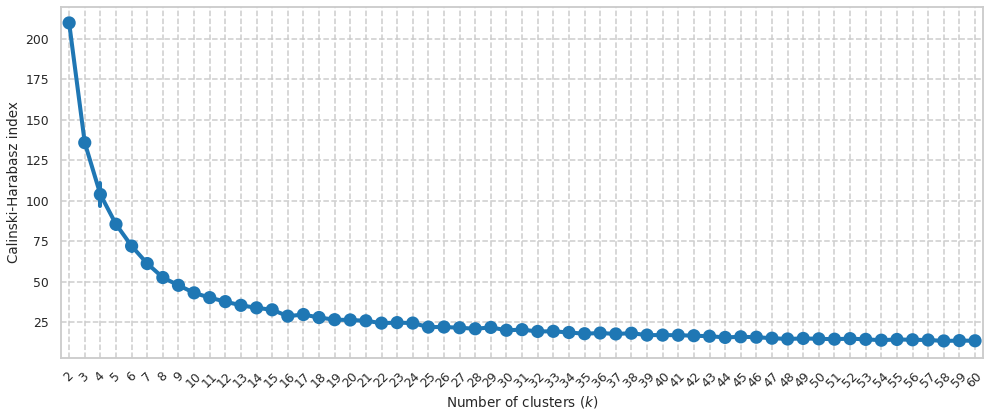

In [40]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score")
    ax.set_ylabel("Calinski-Harabasz index")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [41]:
parts = ensemble.groupby("n_clusters").apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [42]:
parts.head()

n_clusters
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...
4    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
5    [[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0,...
6    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 1.0,...
dtype: object

In [43]:
assert np.all(
    [
        parts.loc[k].shape == (CLUSTERING_OPTIONS["N_REPS_PER_K"], data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [44]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import pdist

In [45]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="k"
)

In [46]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

2     1.000000
3     1.000000
4     0.706709
6     0.654032
5     0.562892
7     0.198969
8     0.158953
9     0.156636
10    0.120957
13    0.102207
12    0.101988
11    0.100751
22    0.090791
14    0.090578
52    0.087660
Name: k, dtype: float64

In [47]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)

In [48]:
parts_ari_df.shape

(59, 10)

In [49]:
assert (
    int(
        (CLUSTERING_OPTIONS["N_REPS_PER_K"] * (CLUSTERING_OPTIONS["N_REPS_PER_K"] - 1))
        / 2
    )
    == parts_ari_df.shape[1]
)

In [50]:
parts_ari_df.head()

,0,1,2,3,4,5,6,7,8,9
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.316450,0.300467,0.312368,0.316450,0.951973,0.978283,1.000000,0.960844,0.951973,0.978283
5,0.255985,0.302420,0.307365,0.257242,0.688087,0.623300,0.989519,0.885976,0.692109,0.626916
6,0.170649,0.963083,0.962127,0.966082,0.168698,0.168155,0.168616,0.995114,0.989385,0.988413


## Save

In [51]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-stability-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/GaussianMixture-stability-COVARIANCE_TYPE_full-K_MAX_60-K_MIN_2-N_INIT_10-N_REPS_PER_K_5.pkl')

In [52]:
parts_ari_df.to_pickle(output_filename)

## Stability plot

In [53]:
parts_ari_df_plot = (
    parts_ari_df.stack()
    .reset_index()
    .rename(columns={"level_0": "k", "level_1": "idx", 0: "ari"})
)

In [54]:
parts_ari_df_plot.dtypes

k        int64
idx      int64
ari    float64
dtype: object

In [55]:
parts_ari_df_plot.head()

,k,idx,ari
0,2,0,1.0
1,2,1,1.0
2,2,2,1.0
3,2,3,1.0
4,2,4,1.0


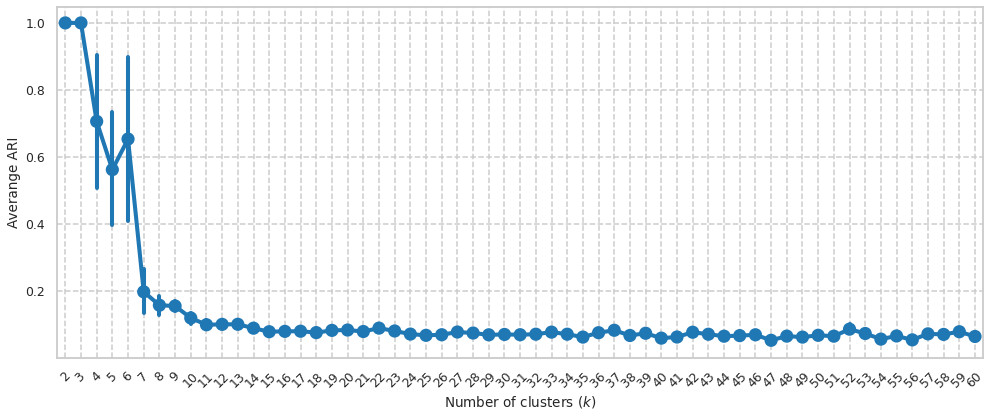

In [56]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="k", y="ari")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()